In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/Users/ferran/PhD/yaleCollab


Ligand **-***sender|receiver***->** Receptor **-->** Pathway **-->** Target 

* L-R interactions from NichetNet (or anything else really)
* Target gene list from Nichenet too. 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

We will have to be carefull with the targets added, as in the previous nichenetKG they were the vast majority of nodes.


# Get data from databases

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Looking for R's HOME:
    Environment variable R_HOME: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Calling `R RHOME`: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/:/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/ferran/miniconda3/envs/collabLite/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/ferran/miniconda3/envs/collabLite/lib', '/Users/ferran/miniconda3/envs/collabLite/lib/R/lib', '/Users/ferran/miniconda3/envs/collabLite/lib']
  extra_compile_args:
  []
  extra_lin

NicheNet

In [5]:
%%R -o dNNlr,dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))
# dNNgrt = readRDS(url("https://zenodo.org/record/3260758/files/tf_target_matrix.rds"))
# dNNlt = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))

In [6]:
print("Ligand-Receptor\n",dNNlr.describe())
print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304
TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691


,from,to,source,database
1,CXCL1,CXCR2,kegg_cytokines,kegg
2,CXCL2,CXCR2,kegg_cytokines,kegg
3,CXCL3,CXCR2,kegg_cytokines,kegg
4,CXCL5,CXCR2,kegg_cytokines,kegg
5,PPBP,CXCR2,kegg_cytokines,kegg
...,...,...,...,...
12647,CXCL6,PIGR,ppi_lr_go,ppi_prediction_go
12648,RLN1,GPR25,ppi_lr_go,ppi_prediction_go
12649,RLN1,RAMP3,ppi_lr_go,ppi_prediction_go
12650,PIK3CB,TNFRSF10A,ppi_bidir_r_go,ppi_prediction_go


On the L-R side, NicheNet seems to have a higher number of interactions
modelled in. We can just use them *as is*.

The tf_target and ligand_target matrix objects don't look to be as useful since the targets they have are actually, if anything, somewaht longer than the targets in the gene regulation database (uncomment .md below to see)
Manual exploration of the tf_target database revealed that all genes with bio meaning I could think of are present in this list.
Afterall,we have 25k genes in here. This is thus, not useful at all.

<!-- Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304

TF-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691

TF-Target 2
 (25345, 4486) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
Ligand-Target
 (25345, 688) [[0.00035343 0.00040413 0.00037299 ... 0.00028765 0.00036615 0.00032276]
 [0.00016509 0.00015092 0.00015836 ... 0.00014044 0.0001839  0.00017542]
 [0.00057872 0.00045963 0.00038959 ... 0.00053559 0.00051685 0.00040327]
 ...
 [0.00043514 0.00052277 0.00040791 ... 0.00043696 0.00092245 0.00045744]
 [0.00041811 0.00049604 0.00045687 ... 0.00036184 0.00059071 0.00040423]
 [0.00050178 0.00055816 0.00048933 ... 0.00053238 0.00099519 0.00057892]] -->
 

Reactome

In [7]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_Pathway.txt", sep="\t", header=None)
dREACTpe = dREACTpe.loc[dREACTpe[7]=="Homo sapiens"][[1,2,3,5]].drop_duplicates() #Rmv duplicates cuz Diff sources
dREACTpe

,1,2,3,5
490283,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-162699,Synthesis of dolichyl-phosphate mannose
490284,R-HSA-4717383,DPM1 G111Lfs*45 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
490285,R-HSA-4717361,DPM1 Q210Rfs*4 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
490286,R-HSA-4717370,DPM1 R92G [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
490287,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-4719360,Defective DPM3 causes DPM3-CDG
...,...,...,...,...
1594196,R-HSA-3209107,p14ARF mRNA [cytosol],R-HSA-8951936,RUNX3 regulates p14-ARF
1594437,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-6807505,RNA polymerase II transcribes snRNA genes
1594438,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-72165,mRNA Splicing - Minor Pathway
1606265,R-HSA-428380,MYC mRNA [cytosol],R-HSA-428359,Insulin-like Growth Factor-2 mRNA Binding Prot...


Now, grab the receptors by name in column 2 of dRpe and targets too, to build Receptor->pathway and pathway->targets triples.

* To grab genes/protein, we have to match the NN name with a regex that looks for string start, full match, space, and [ bracket.

In [8]:
dREACTnodes = dREACTpe.loc[dREACTpe[2].str.match("^[A-Z0-9]+(\(\S+\))? \[")][[2,3,5]]#Some entries belong to proteins with no gene entry (like CLU), so we have to use ().
dREACTnodes[2] = dREACTnodes[2].str.extract("^([A-Z0-9]+)")[0]
dREACTnodes = dREACTnodes.drop_duplicates()
dREACTnodes

,2,3,5
490283,DPM1,R-HSA-162699,Synthesis of dolichyl-phosphate mannose
490287,DPM1,R-HSA-4719360,Defective DPM3 causes DPM3-CDG
490288,DPM1,R-HSA-4719377,Defective DPM2 causes DPM2-CDG
490295,FGR,R-HSA-2029481,FCGR activation
490296,FGR,R-HSA-432142,Platelet sensitization by LDL
...,...,...,...
664398,UGT1A3,R-HSA-9754706,Atorvastatin ADME
664399,UGT1A3,R-HSA-9757110,Prednisone ADME
664405,UGT1A5,R-HSA-156588,Glucuronidation
664406,UGT1A5,R-HSA-9749641,Aspirin ADME


In [9]:
del dREACTpe

In [10]:
dR2Path = dREACTnodes.loc[dREACTnodes[2].isin(dNNlr["to"])]
dR2Path


,2,3,5
490355,CFTR,R-HSA-382556,ABC-family proteins mediated transport
490357,CFTR,R-HSA-5627083,RHO GTPases regulate CFTR trafficking
490369,CFTR,R-HSA-5689880,Ub-specific processing proteases
490373,CFTR,R-HSA-9013406,RHOQ GTPase cycle
490446,CD99,R-HSA-198933,Immunoregulatory interactions between a Lympho...
...,...,...,...
659695,OR8D2,R-HSA-9752946,Expression and translocation of olfactory rece...
661157,ADORA3,R-HSA-417973,Adenosine P1 receptors
661158,ADORA3,R-HSA-418594,G alpha (i) signalling events
664391,NPBWR1,R-HSA-375276,Peptide ligand-binding receptors


In [11]:
dPath2Gene = dREACTnodes.loc[dREACTnodes[2].isin(dNNgr["to"]) & ~dREACTnodes[2].isin(dNNlr["from"]) & ~dREACTnodes[2].isin(dNNlr["to"]) & ~dREACTnodes[2].isin(dNNgr["from"])]
print(dPath2Gene[2].unique().shape)
dPath2Gene

(6534,)


,2,3,5
490283,DPM1,R-HSA-162699,Synthesis of dolichyl-phosphate mannose
490287,DPM1,R-HSA-4719360,Defective DPM3 causes DPM3-CDG
490288,DPM1,R-HSA-4719377,Defective DPM2 causes DPM2-CDG
490295,FGR,R-HSA-2029481,FCGR activation
490296,FGR,R-HSA-432142,Platelet sensitization by LDL
...,...,...,...
662801,ARHGAP11B,R-HSA-9013148,CDC42 GTPase cycle
664293,OR4F4,R-HSA-9752946,Expression and translocation of olfactory rece...
664405,UGT1A5,R-HSA-156588,Glucuronidation
664406,UGT1A5,R-HSA-9749641,Aspirin ADME


Note that some pathways are connected only to Receptors or to other gene nodes.

In [12]:
del dREACTnodes

# Build triples dataframe

In [13]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dR2Path = pd.DataFrame({
            "head":dR2Path[2],
            "relation":np.repeat("R2Path", dR2Path.shape[0]),
            "tail":dR2Path[3]
        })
dPath2Gene = pd.DataFrame({
            "head":dPath2Gene[3],
            "relation":np.repeat("Path2Gene", dPath2Gene.shape[0]),
            "tail":dPath2Gene[2]
        })

dKGnn = pd.concat([dNNlr, dR2Path, dPath2Gene]).drop_duplicates().reset_index(drop=True)
del dNNlr,dR2Path,dPath2Gene
dKGnn

,head,relation,tail
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
34393,R-HSA-9013148,Path2Gene,ARHGAP11B
34394,R-HSA-9752946,Path2Gene,OR4F4
34395,R-HSA-156588,Path2Gene,UGT1A5
34396,R-HSA-9749641,Path2Gene,UGT1A5


In [14]:
dKGnn.to_csv(f"{data_dir}/dKGnn2.csv.tar.gz", index=False, header=False)

In [15]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn2.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
34393,R-HSA-9013148,Path2Gene,ARHGAP11B
34394,R-HSA-9752946,Path2Gene,OR4F4
34395,R-HSA-156588,Path2Gene,UGT1A5
34396,R-HSA-9749641,Path2Gene,UGT1A5


# NetworkX KG

In [16]:
G = networkx.from_pandas_edgelist(dKGnn,source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

Graph with 9552 nodes and 34341 edges, with a density of 0.000752834952692475
We have this many isolates:  0
The graph is connected: False

We have 97 connected subgraphs
Component 1: Graph with 8794 nodes and 33488 edges, with a density of 0.0008661551106164757
Component 2: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 3: Graph with 1 nodes and 1 edges, with a density of 0
Component 4: Graph with 4 nodes and 4 edges, with a density of 0.6666666666666666
Component 5: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 22 nodes and 24 edges, with a density of 0.1038961038961039
Component 8: Graph with 251 nodes and 250 edges, with a density of 0.00796812749003984
Component 9: Graph with 5 nodes and 4 edges, with a density of 0.4
Component 10: Graph with 4 nodes and 3 edges, with a density of 0.5
Component 11: Graph with 41 nodes and 49 edges, with a density of 0.

/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_80537/1504231106.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_80537/1504231106.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


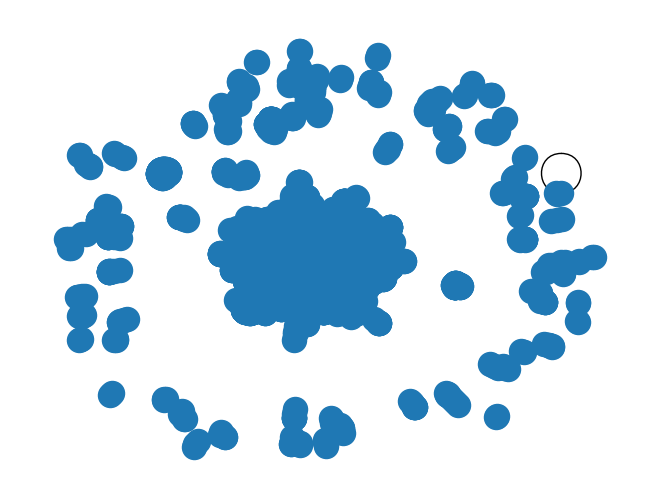

In [17]:
networkx.draw_networkx(G)

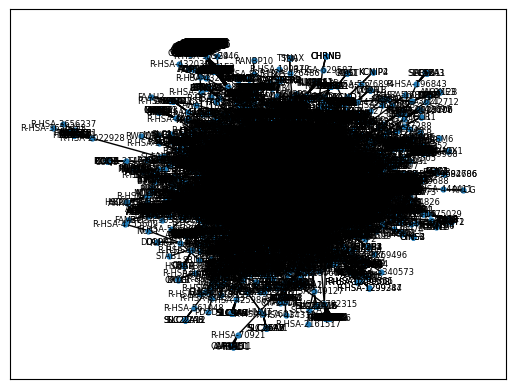

In [25]:
networkx.draw_networkx(Gcomponents[0], node_size=12, font_size=6)#Biggest subcomponent

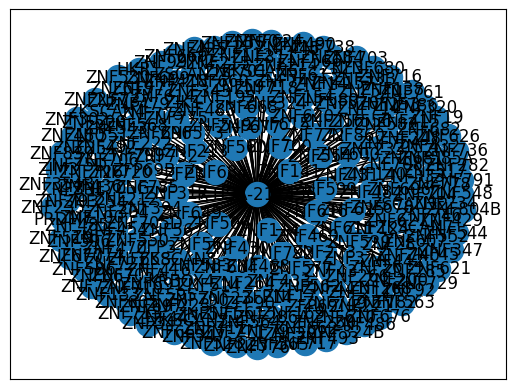

In [23]:
networkx.draw_networkx(Gcomponents[7], node_size=12, font_size=6)#Second biggest subcomponent are Zinc Finger Nucleases!

## Full graph

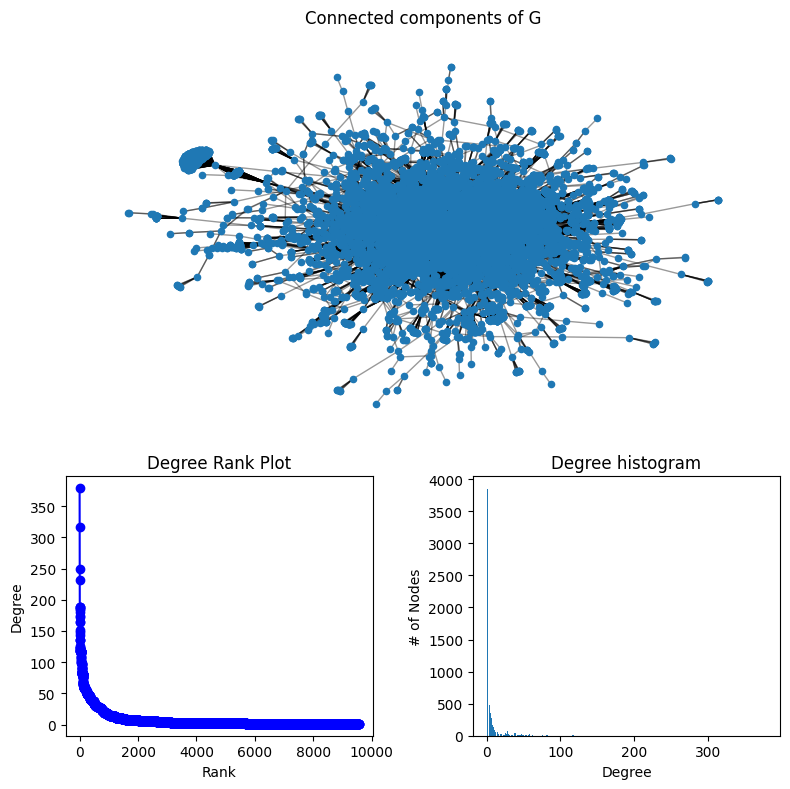

In [20]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# KG Embedding

In [26]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [27]:
tf = TriplesFactory.from_labeled_triples(
        dKGnn.to_numpy(dtype="str"),create_inverse_triples=False)
tf

import json
with open(f"{data_dir}/dKGnn2_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

: 

In [ ]:
modelKGE = "KGnn2_50_unstratified_stopped_transe"

In [ ]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=10,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()